# Joining our Data Sets together
  >### Importing our R package

  > ##### Uncomment to download the data package

In [1]:
install.packages("remotes")
remotes::install_github("chenthih/nzmentalquake")
library(tidyverse)


The downloaded binary packages are in
	/var/folders/h1/hsvn81y50_96s2h0d8q5zx040000gn/T//Rtmp2K7J0W/downloaded_packages


crayon (1.4.1 -> 1.4.2) [CRAN]


Installing 1 packages: crayon




  There is a binary version available but the source version is later:
       binary source needs_compilation
crayon  1.4.1  1.4.2             FALSE



installing the source package ‘crayon’




✔  checking for file ‘/private/var/folders/h1/hsvn81y50_96s2h0d8q5zx040000gn/T/Rtmp2K7J0W/remotesf23551ad627/chenthih-nzmentalquake-0949291/DESCRIPTION’
─  preparing ‘nzmentalquake’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘nzmentalquake_0.0.1.1000.tar.gz’
   


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



> load population_by_city

>      mental_health_by_city

>      earthquake_summary_dataset

>      earthquake_dataset

In [2]:
# load all the table we need
eq_df <- nzmentalquake::earthquake_dataset
eq_summary_df <- nzmentalquake::earthquake_summary_dataset
mh_df <- nzmentalquake::mental_health_dataset %>% select(-1) 
pop_df <- nzmentalquake::population_dataset %>% select(-1)

### Plot 1: Earthquake Map

In [3]:
library(ggplot2)
library(dplyr)

install.packages('maps')
library(maps)

NZ <- map_data("nz")


The downloaded binary packages are in
	/var/folders/fd/ly5mksl541v526fd48sjdfcm0000gn/T//RtmpL62G5q/downloaded_packages



Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




#### First, we use the ggplot function to draw a map of NZ, and then mark the locations of all earthquakes on it, using different colors to represent different cities, red for Auckland, green for Canterbury, and blue for Wellington. It can be seen that the number of earthquakes in Wellington and Canterbury is relatively high.

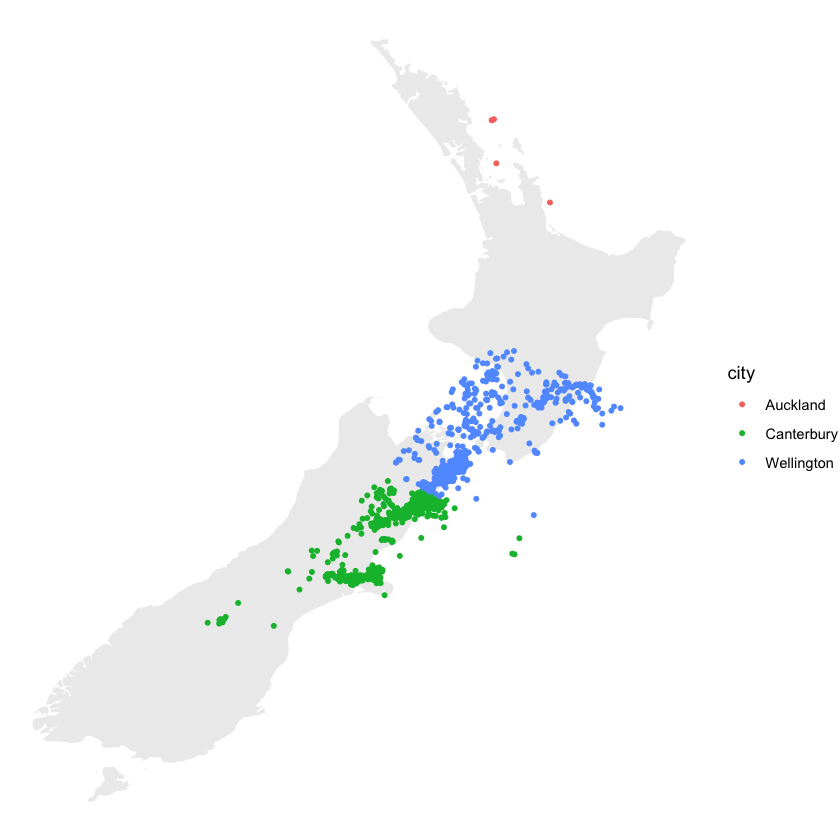

In [4]:
ggplot() +
  geom_polygon(data = NZ, aes(x=long, y = lat, group = group), fill="grey", alpha=0.3) +
  geom_point(data=nzmentalquake::earthquake_dataset, aes(x=longitude, y=latitude, col=city), size=1) +
  theme_void()

#### Earhquake map version 2:
Size by magnitude, colour by depth. Bigger the dot stronger the magnitude, the lighter the deeper.
(Dots in bigger size with darker colour have more impact)

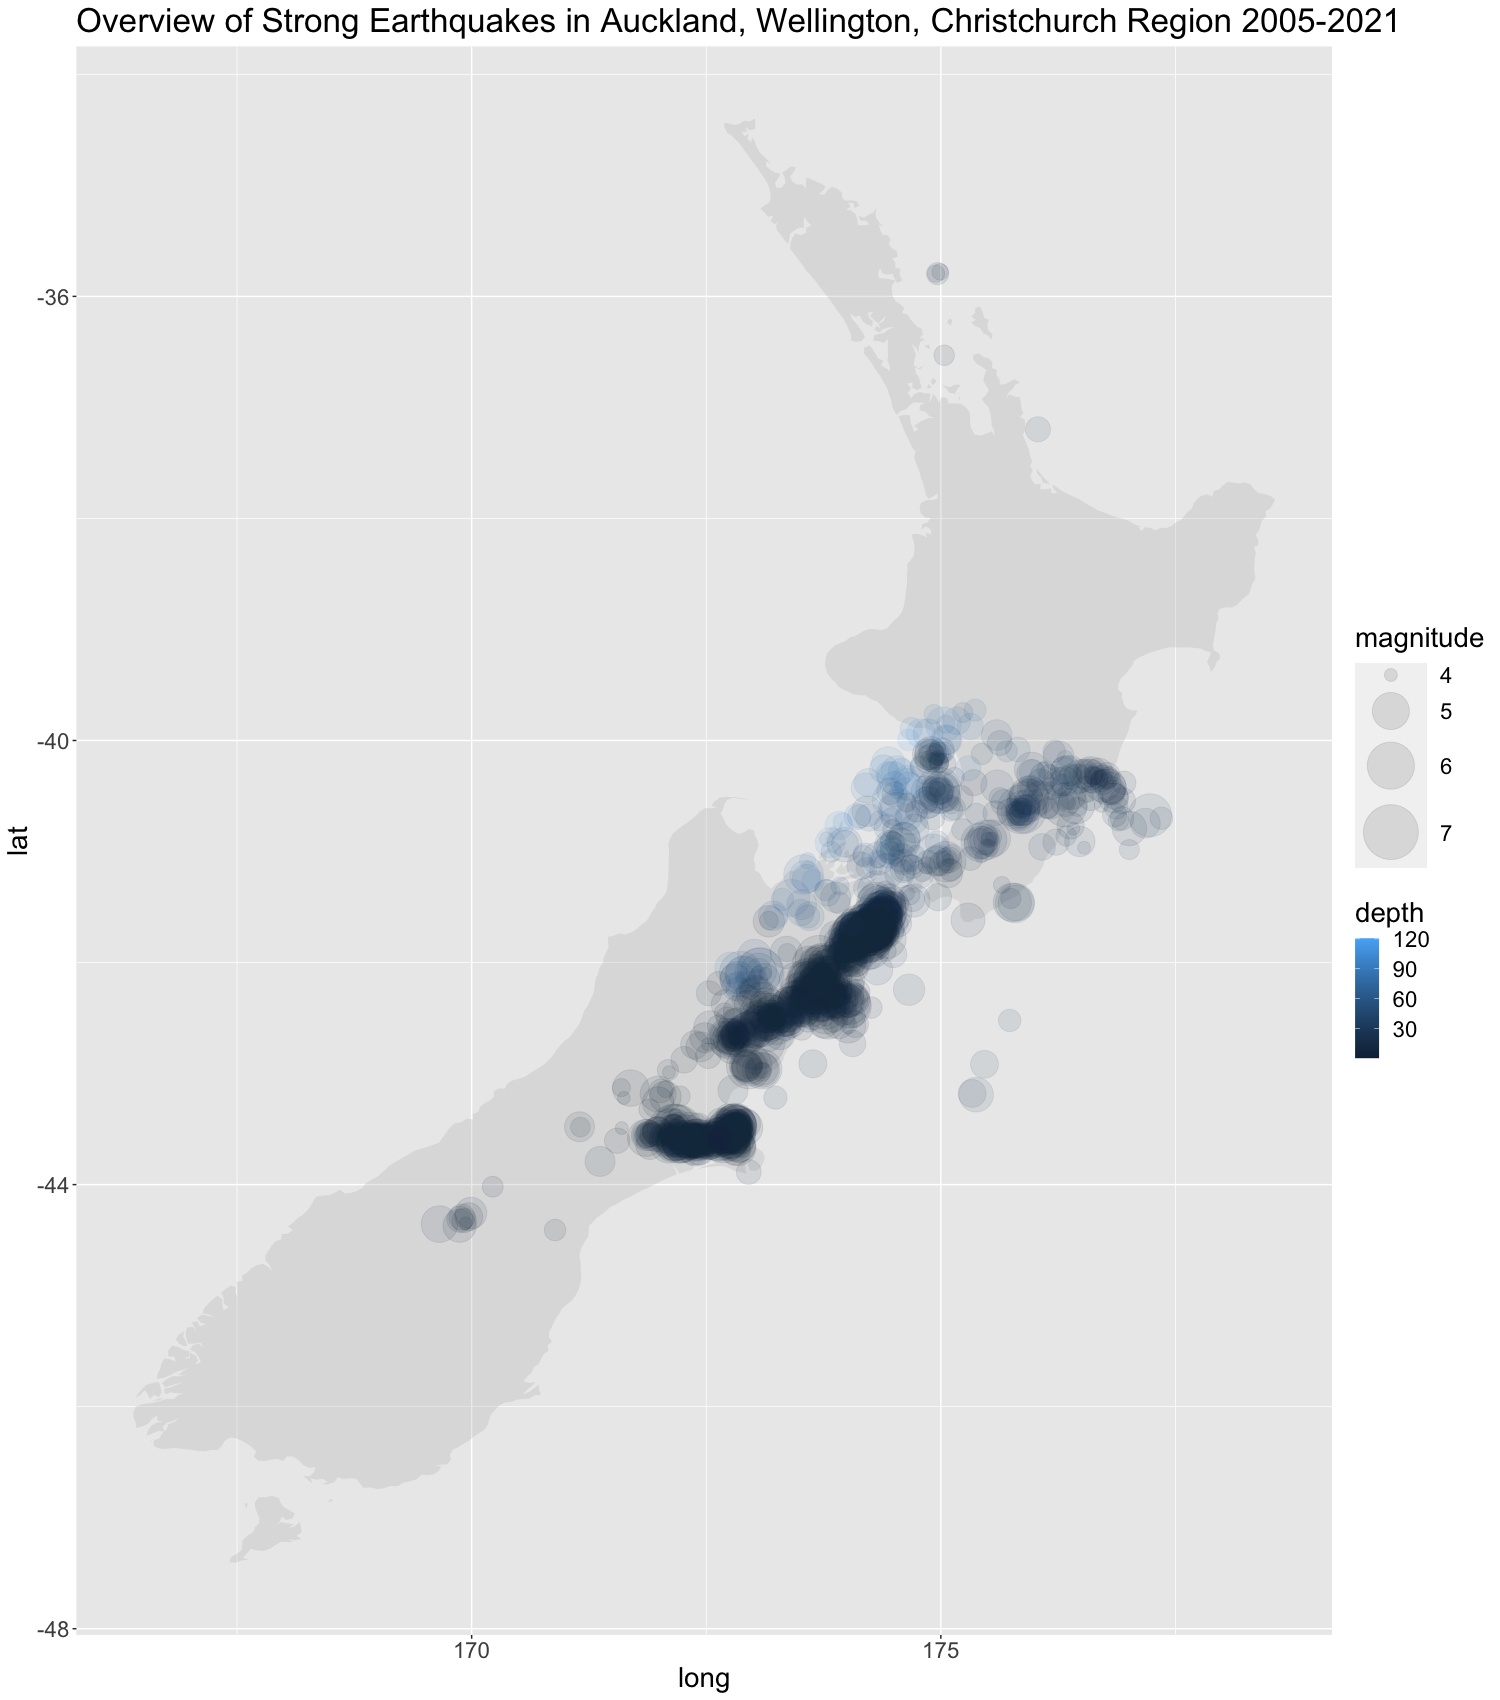

In [5]:
options(repr.plot.width = 15, repr.plot.height = 17, repr.plot.res = 100)

quake_map <- ggplot() +
  geom_polygon(data = NZ, aes(x=long, y = lat, group = group), fill="grey", alpha=0.3) +
  geom_point(data=nzmentalquake::earthquake_dataset, aes(x=longitude, y=latitude, col=depth, size=magnitude), alpha=0.1) +
  scale_size_continuous(range=c(4,20)) +
  ggtitle("Overview of Strong Earthquakes in Auckland, Wellington, Christchurch Region 2005-2021") +
  theme(text = element_text(size=20))

quake_map

## Joining Tables

##### In the Mental Health and Earthquake sets Use city and year as the primary key, and after that FILTER out the total number of people in mental health, which is the total attribute. 


In [5]:
joined_table <- eq_summary_df %>% full_join(mh_df, by=c('City','Year')) %>%
        full_join(pop_df, by=c('City','Year')) %>%
        filter(Sex=='Total') %>% #na.omit()
        mutate(mh.change = if_else(City == lag(City), Total - lag(Total), Total-Total),
               mh.change = na_if(mh.change, 0),
               mh.change.rate = mh.change/Total,
               pop.change.rate = Pop.change/Total.Pop,
               mh.per.pop = Total/Total.Pop
              )

# These are all the attributes of the table
joined_table %>% head()

,X,City,Year,Number_of_eq,Average_mag,Max_mag,Sex,Total,Total.Pop,Pop.change,mh.change,mh.change.rate,pop.change.rate,mh.per.pop
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,Auckland,2007,1,4.100000,4.100000,Total,38441,1545100,19400,NA,NA,0.01255582,0.02487930
2,2,Auckland,2010,1,4.255000,4.255000,Total,41114,1600200,20300,2673,0.0650143503,0.01268591,0.02569304
3,3,Auckland,2019,3,4.068303,4.148209,Total,65813,1870100,29500,24699,0.3752905961,0.01577456,0.03519224
4,4,Canterbury,2005,5,4.302400,4.700000,Total,11000,531900,NA,NA,NA,NA,0.02068058
5,5,Canterbury,2006,3,4.188000,4.464000,Total,10998,540000,8100,-2,-0.0001818512,0.01500000,0.02036667
6,6,Canterbury,2007,8,4.368750,5.500000,Total,10836,547400,7400,-162,-0.0149501661,0.01351845,0.01979540


##### Export the final combined dataframe as a one csv file

In [7]:
write.csv(joined_table, "nzmentalquake_data.csv")             

## Line graph - Population change and number of mental health patients

##### Dashed lines represent rate of change in number of mental health patients, solid lines represent estimated population in the regions.

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.
>Red lines -> Akl, blue lines -> Welly, green -> Canterbury.

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


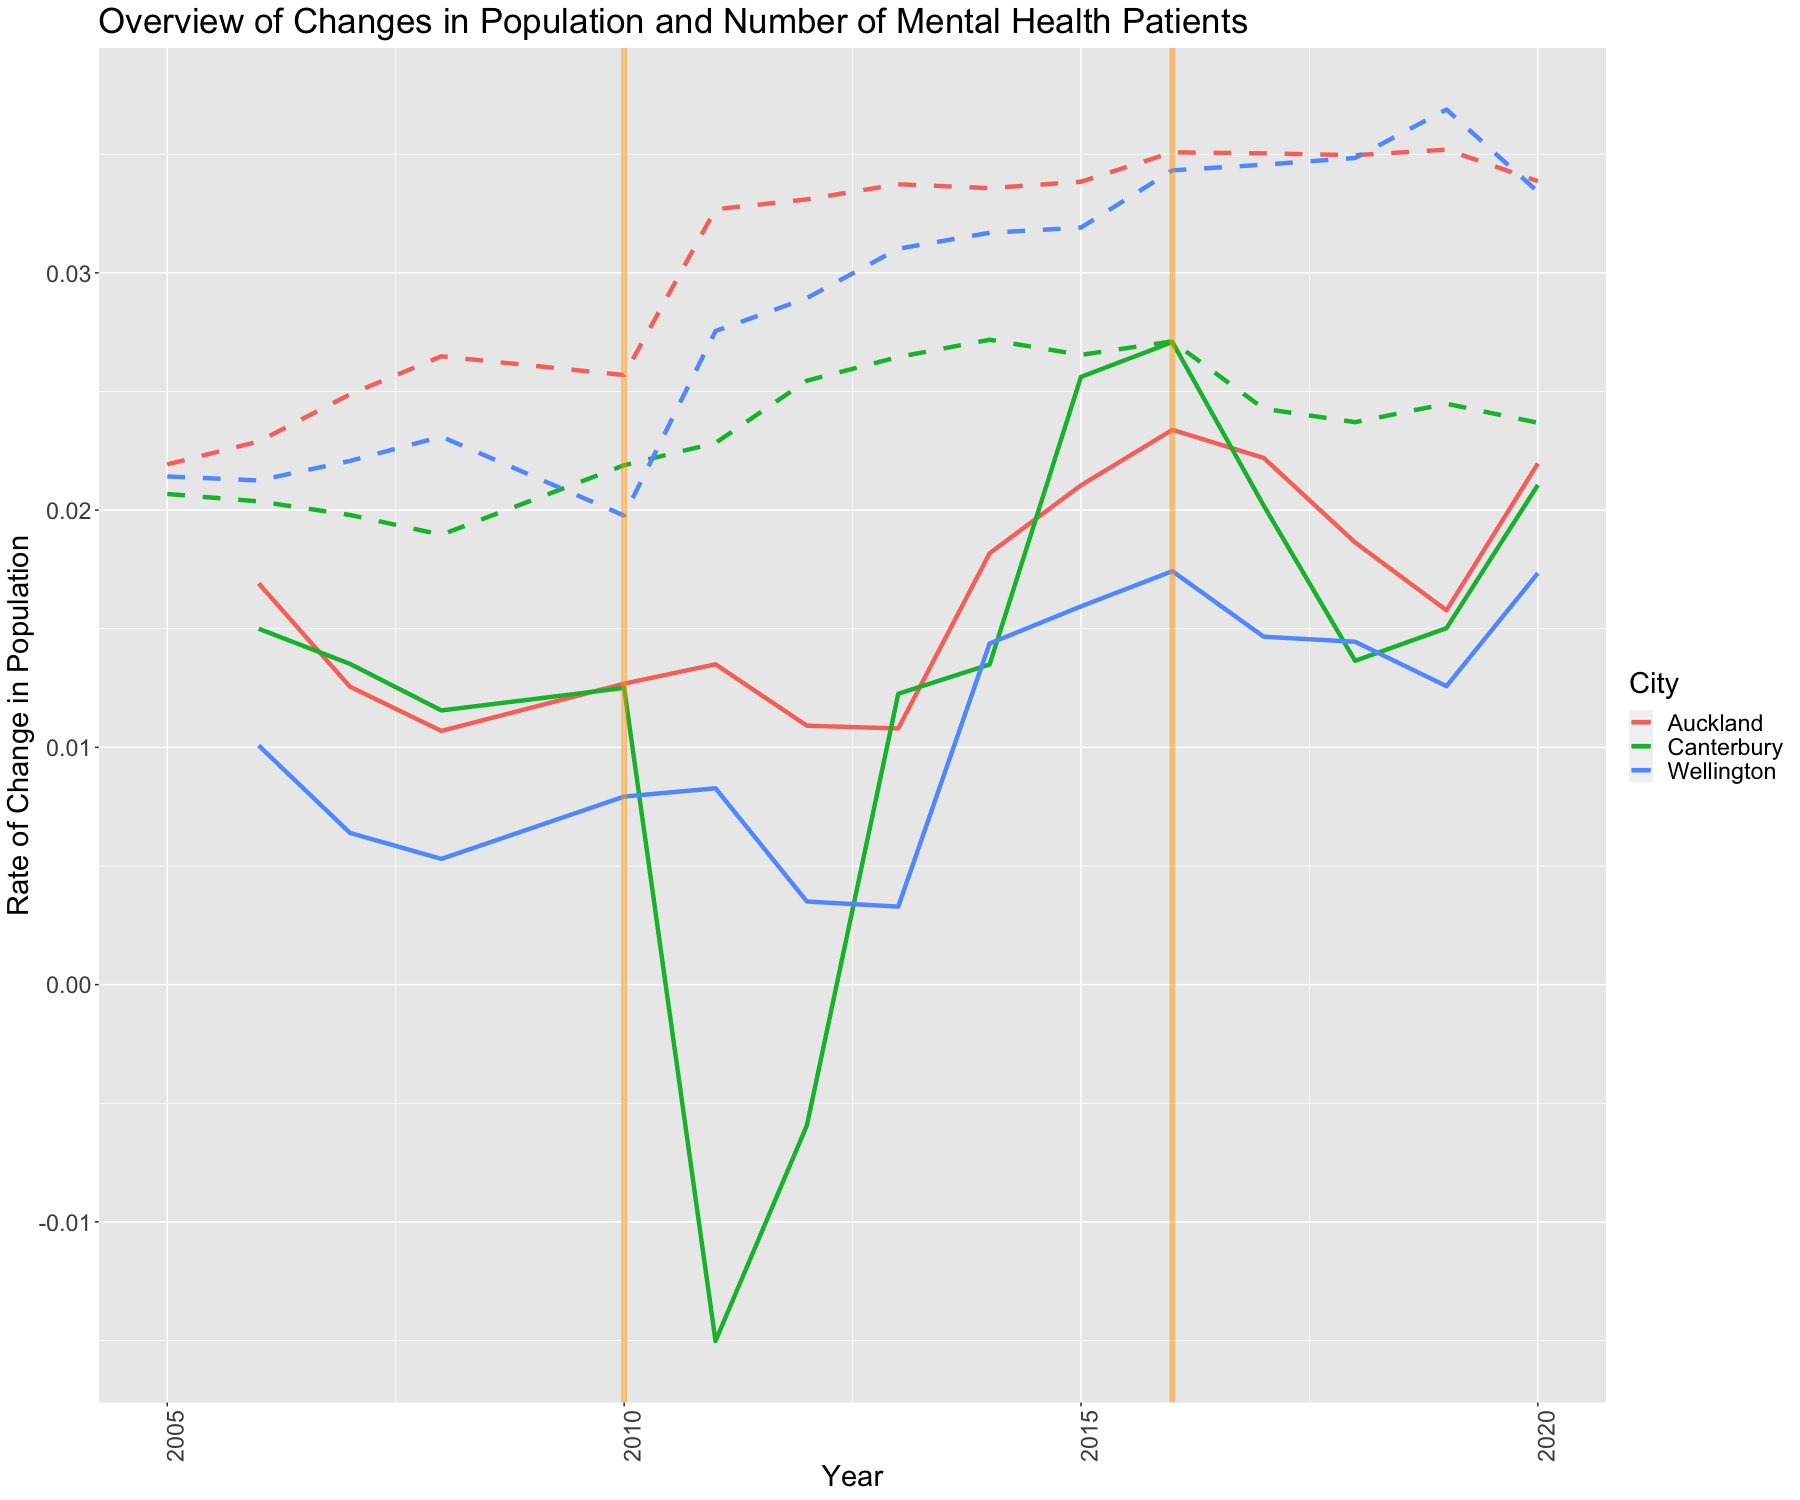

In [6]:
options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.res = 100)

joined_table %>% 
  ggplot( aes(x=Year)) +
    geom_line(aes(y=pop.change.rate, group=City, color=City), size=1.5) + # pop change
    geom_line(aes(y=mh.per.pop, group=City, color=City), size=1.5, linetype='dashed') + # Mental health
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5) +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5) +
    ggtitle("Overview of Changes in Population and Number of Mental Health Patients") +
    ylab("Rate of Change in Population") +
    theme(text = element_text(size=21),
        axis.text.x = element_text(angle=90, hjust=1))


##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>blue line -> population, blue -> number of EQ.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


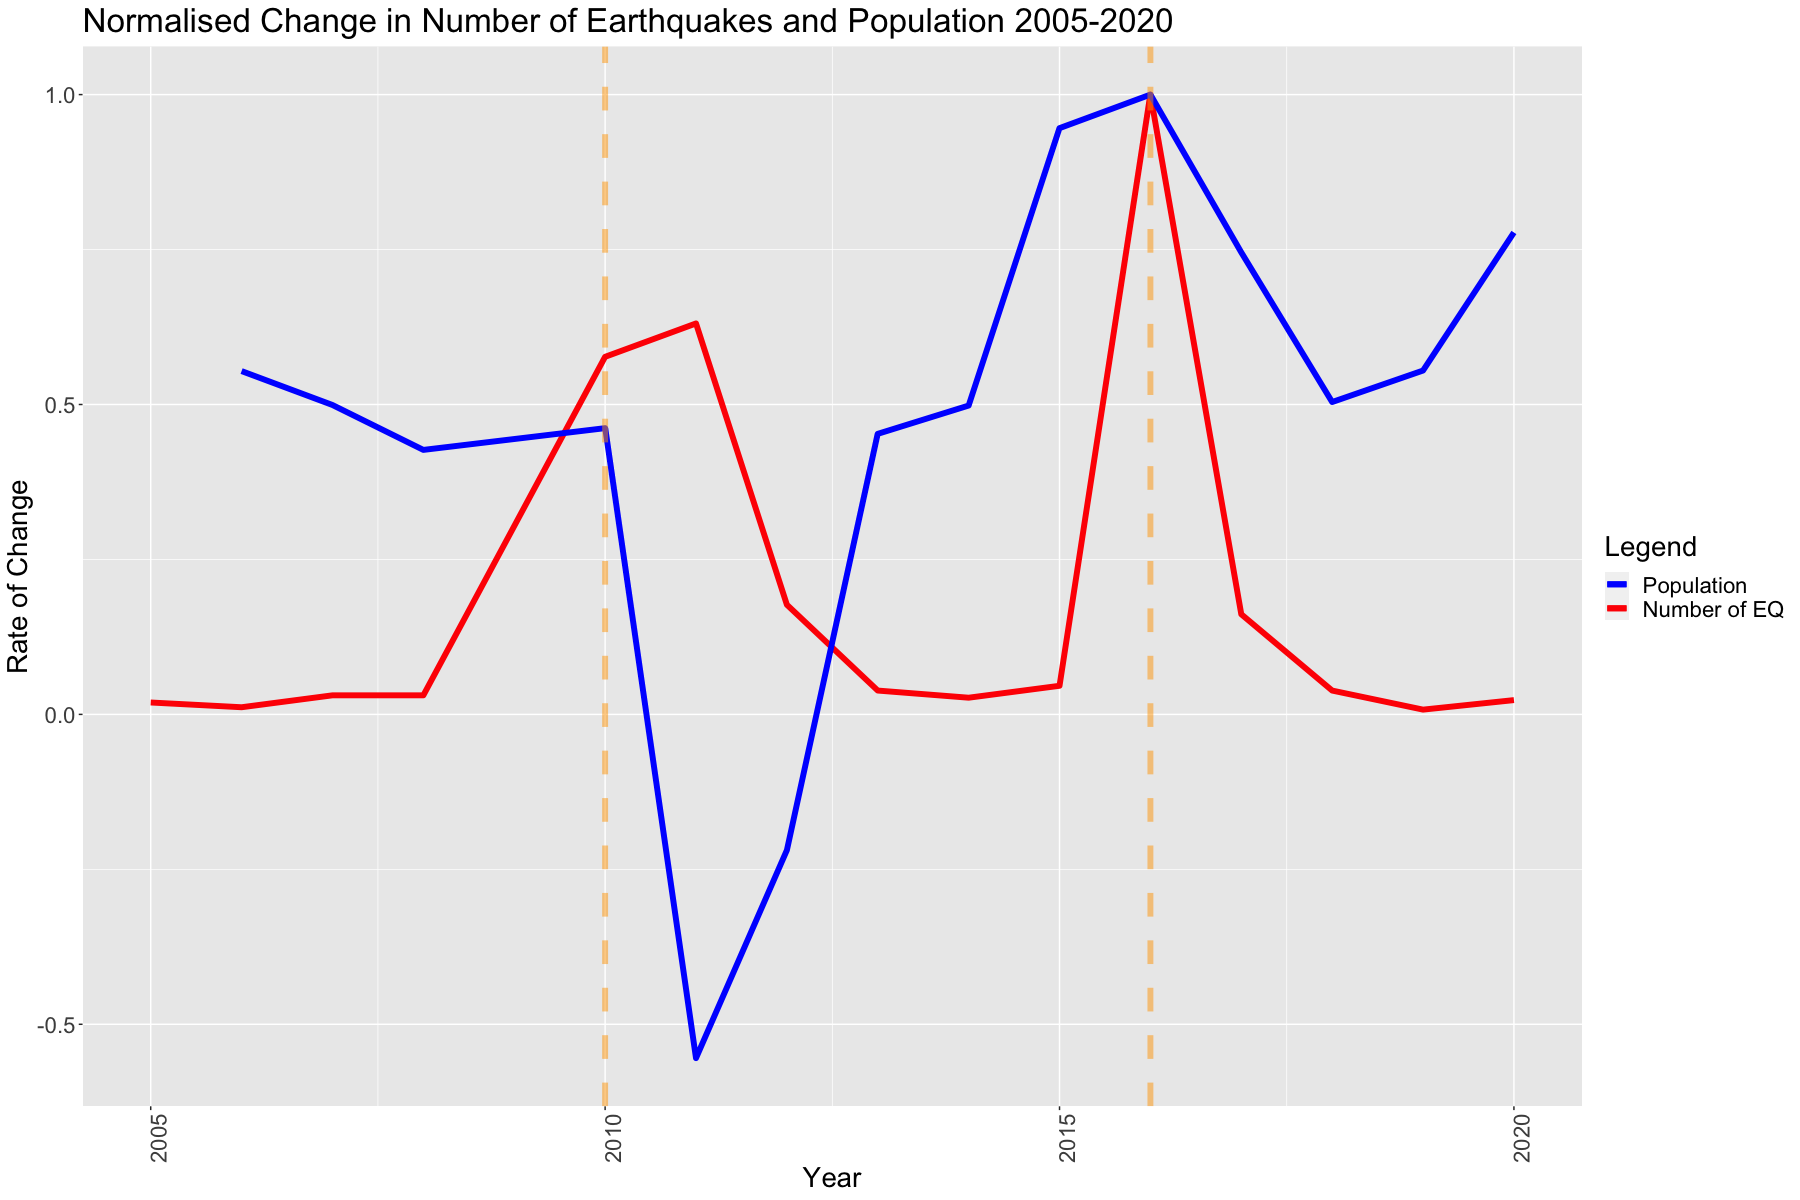

In [8]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 100)

# defining colour
colours <- c("Population" = "blue", "Number of EQ" = "red")

# num eq change rate vs pop change rate for Canterbury
joined_table %>% filter(City=='Canterbury') %>%
  ggplot( aes(x=Year)) +
    geom_line(aes(y=Number_of_eq/max(Number_of_eq, na.rm=TRUE), color="Number of EQ"), size=2) + # normalised num quakes
    geom_line(aes(y=pop.change.rate/max(pop.change.rate, na.rm=TRUE), color='Population'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Change in Number of Earthquakes and Population 2005-2020") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>blue line -> population change amount, red -> Average of magnitude.

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


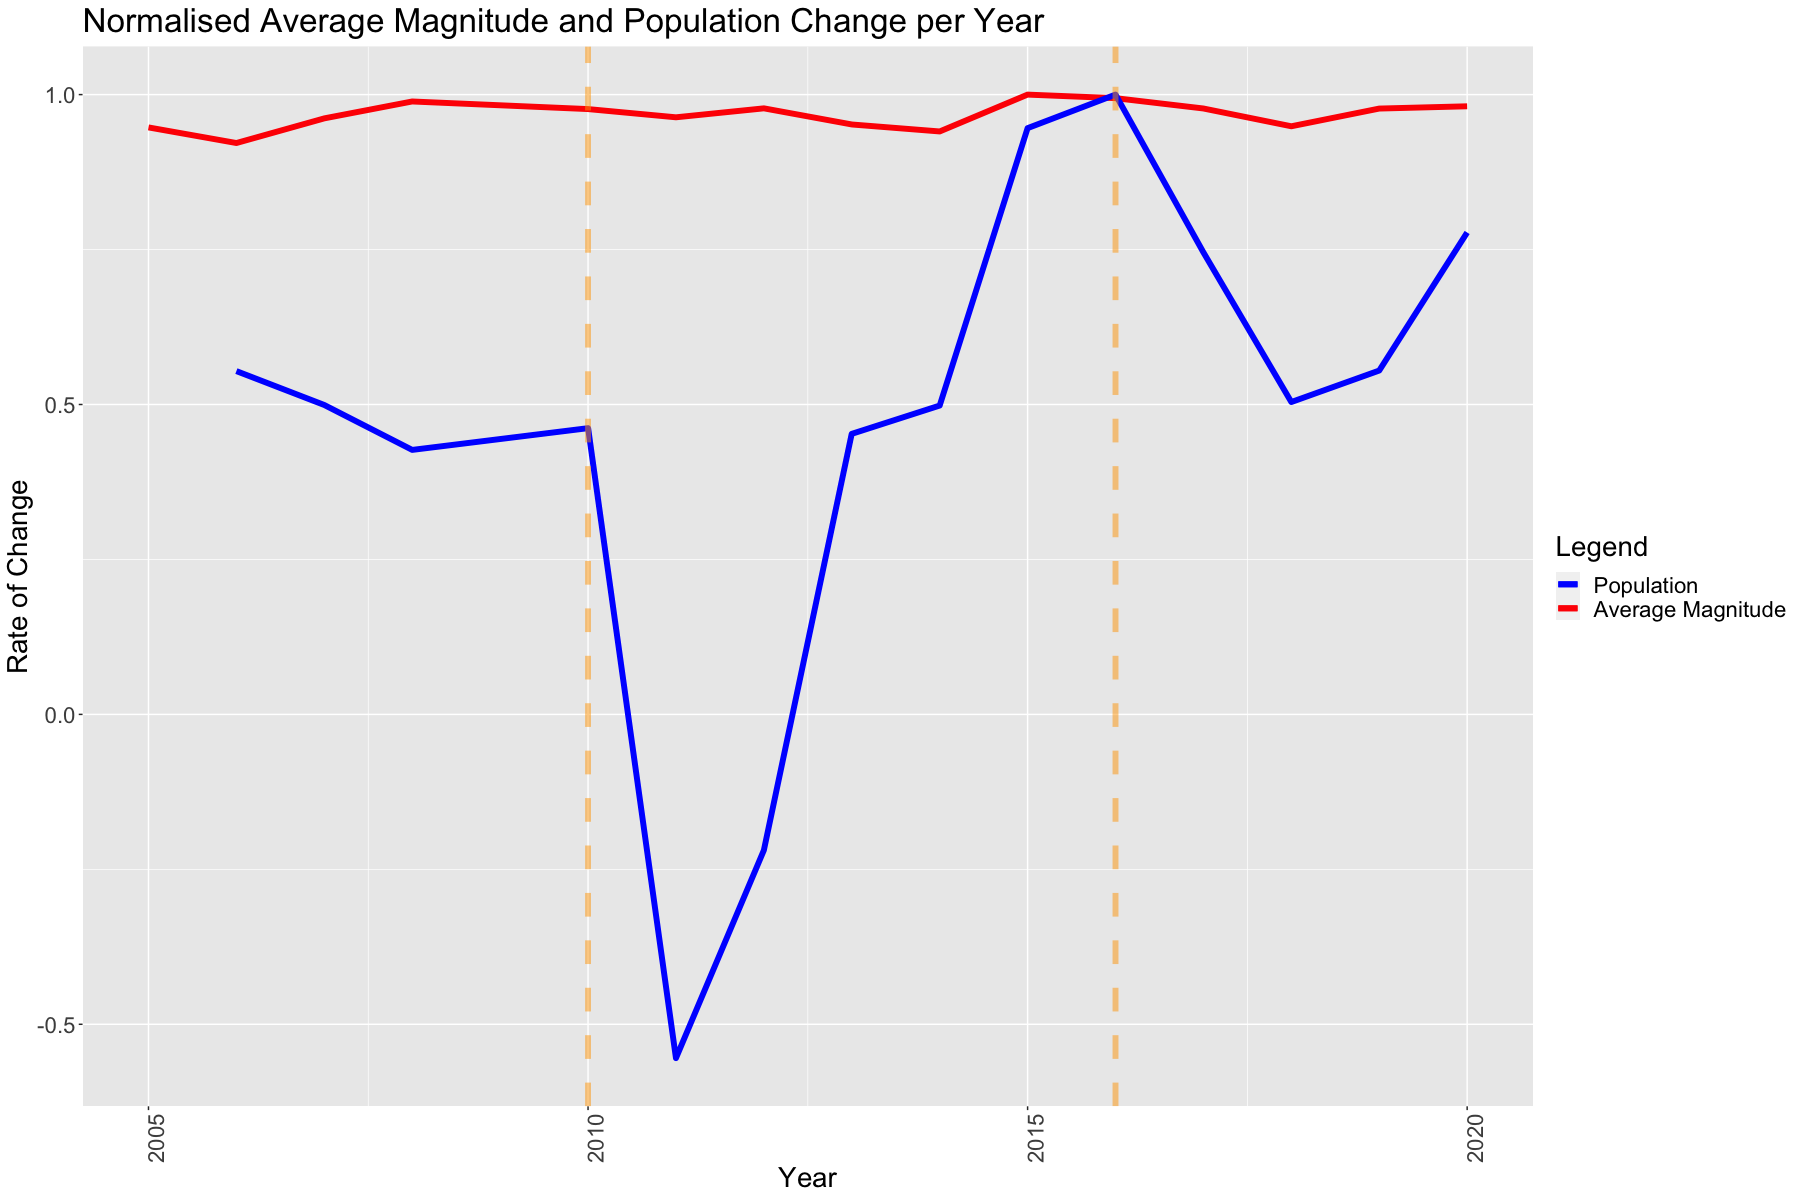

In [10]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 100)

# defining colour
colours2 <- c("Population" = "blue", "Average Magnitude" = "red")

# avg mag vs pop change rate for Canterbury
joined_table %>% filter(City=='Canterbury') %>%
  ggplot( aes(x=Year)) +
    geom_line(aes(y=Average_mag/max(Average_mag, na.rm=TRUE), color="Average Magnitude"), size=2) + # normalised num quakes
    geom_line(aes(y=pop.change.rate/max(pop.change.rate, na.rm=TRUE), color='Population'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Average Magnitude and Population Change per Year") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours2) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>blue line -> population, red -> normalised maximum magnitude

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


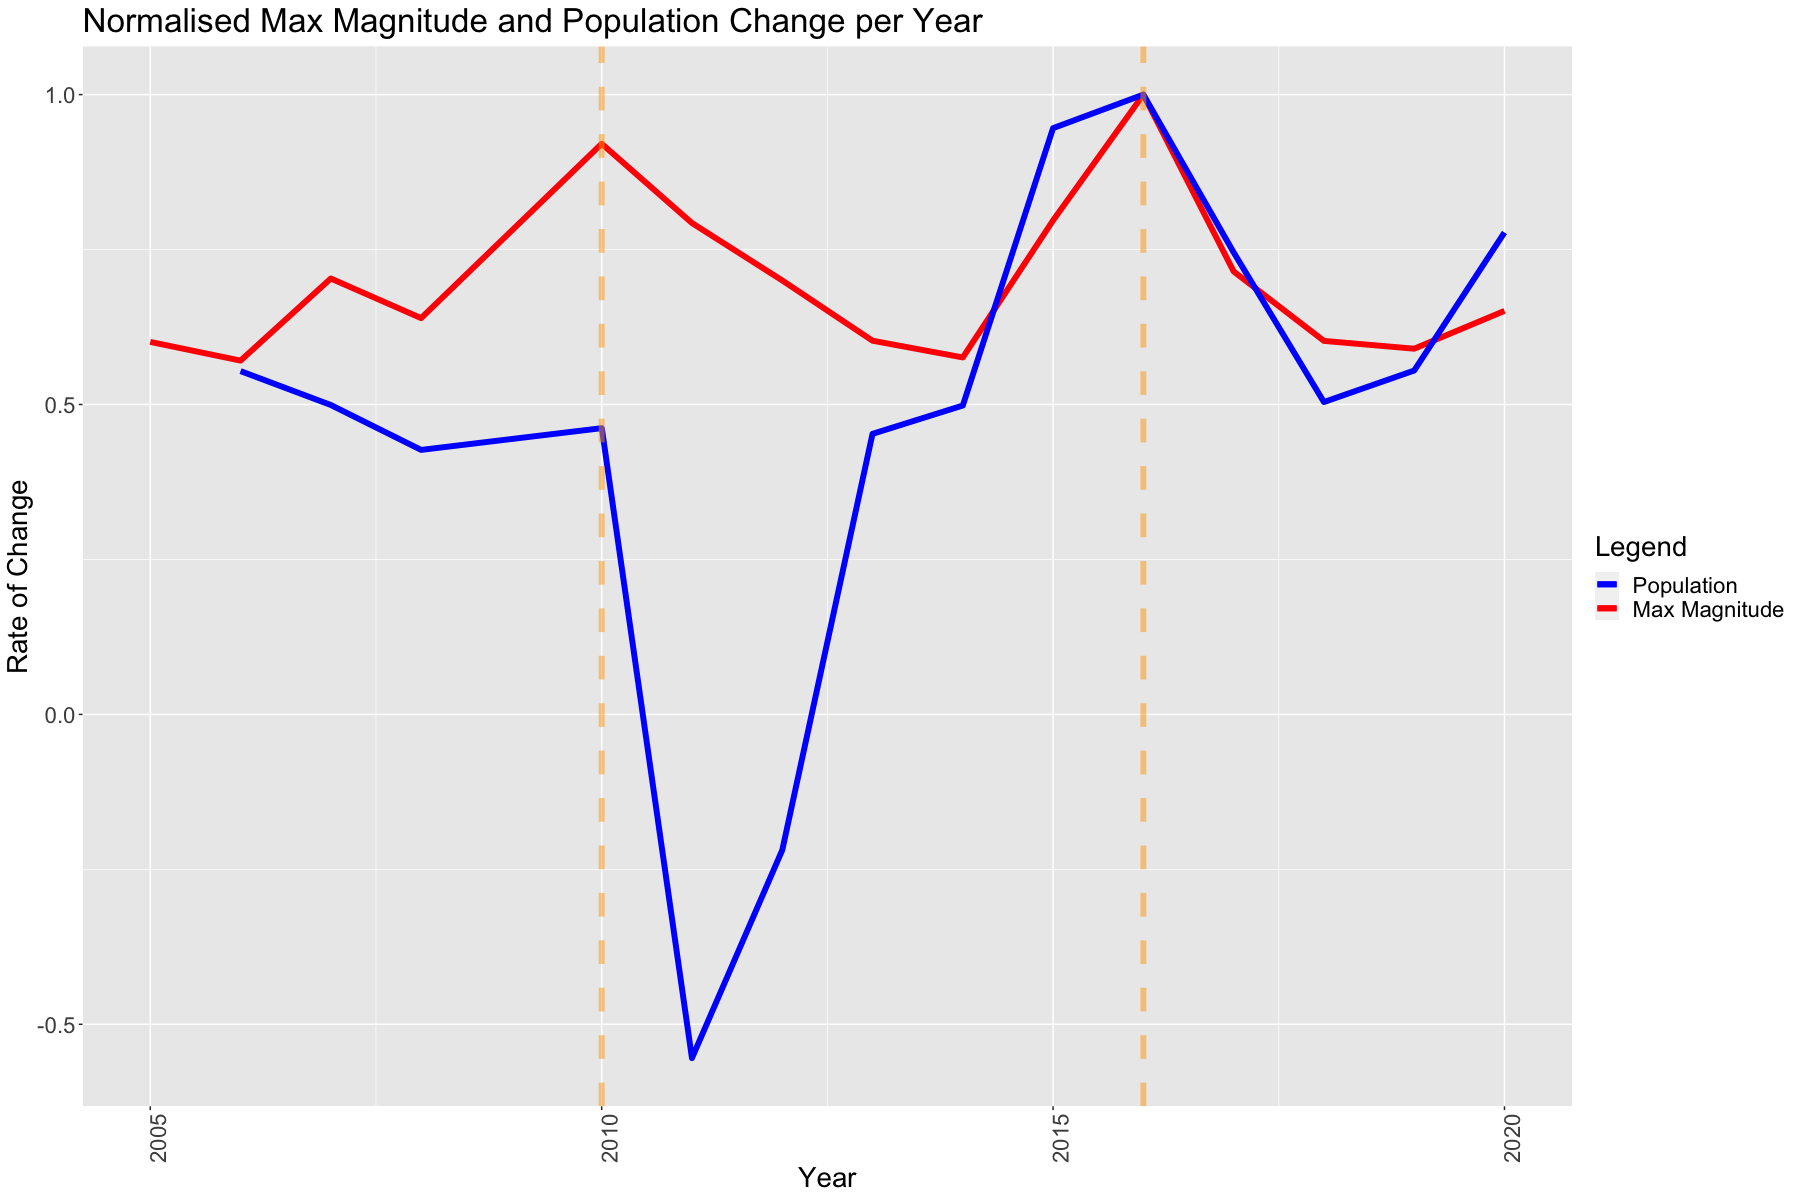

In [12]:
# defining colour
colours3 <- c("Population" = "blue", "Max Magnitude" = "red")

# max mag vs pop change rate for Canterbury
joined_table %>% filter(City=='Canterbury') %>%
  ggplot( aes(x=Year)) +
    geom_line(aes(y=Max_mag/max(Max_mag, na.rm=TRUE), color="Max Magnitude"), size=2) + # normalised num quakes
    geom_line(aes(y=pop.change.rate/max(pop.change.rate, na.rm=TRUE), color='Population'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Max Magnitude and Population Change per Year") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours3) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>green line -> population of mental health, red -> number of EQ

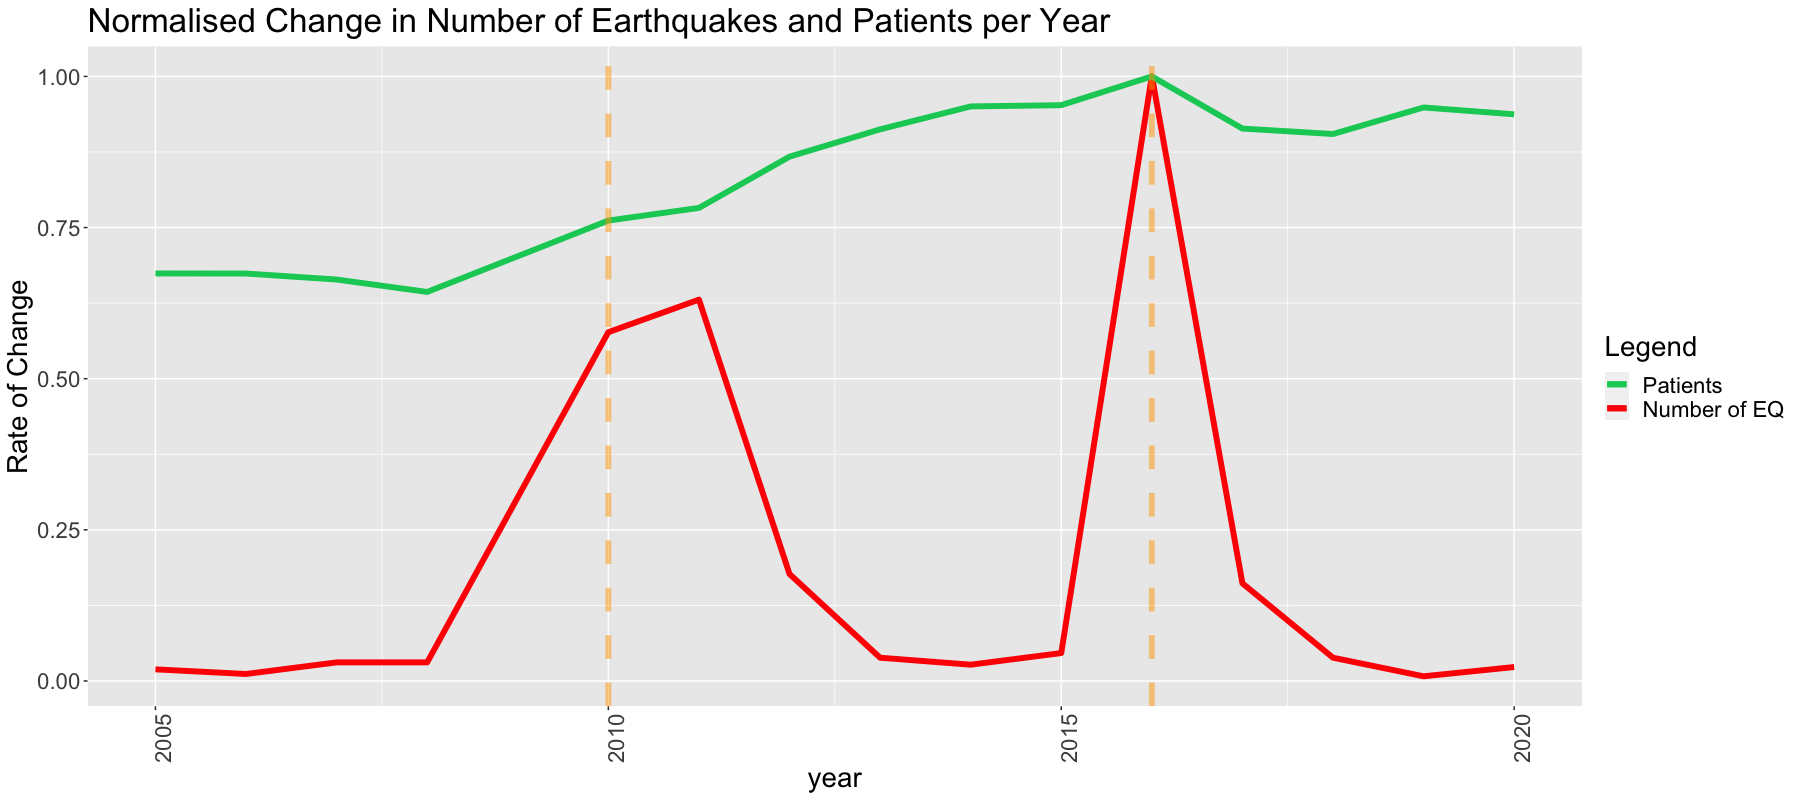

In [276]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 100)

# defining colour
colours <- c("Patients" = "springgreen3", "Number of EQ" = "red")

# num eq change rate vs mental health patients change rate for Canterbury
joined_table %>% filter(city=='Canterbury') %>%
  ggplot( aes(x=year)) +
    geom_line(aes(y=Number_of_eq/max(Number_of_eq, na.rm=TRUE), color="Number of EQ"), size=2) + # normalised num quakes
    geom_line(aes(y=total/max(total, na.rm=TRUE), color='Patients'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Change in Number of Earthquakes and Patients per Year") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>green line -> population of mental health, red -> average magnitude

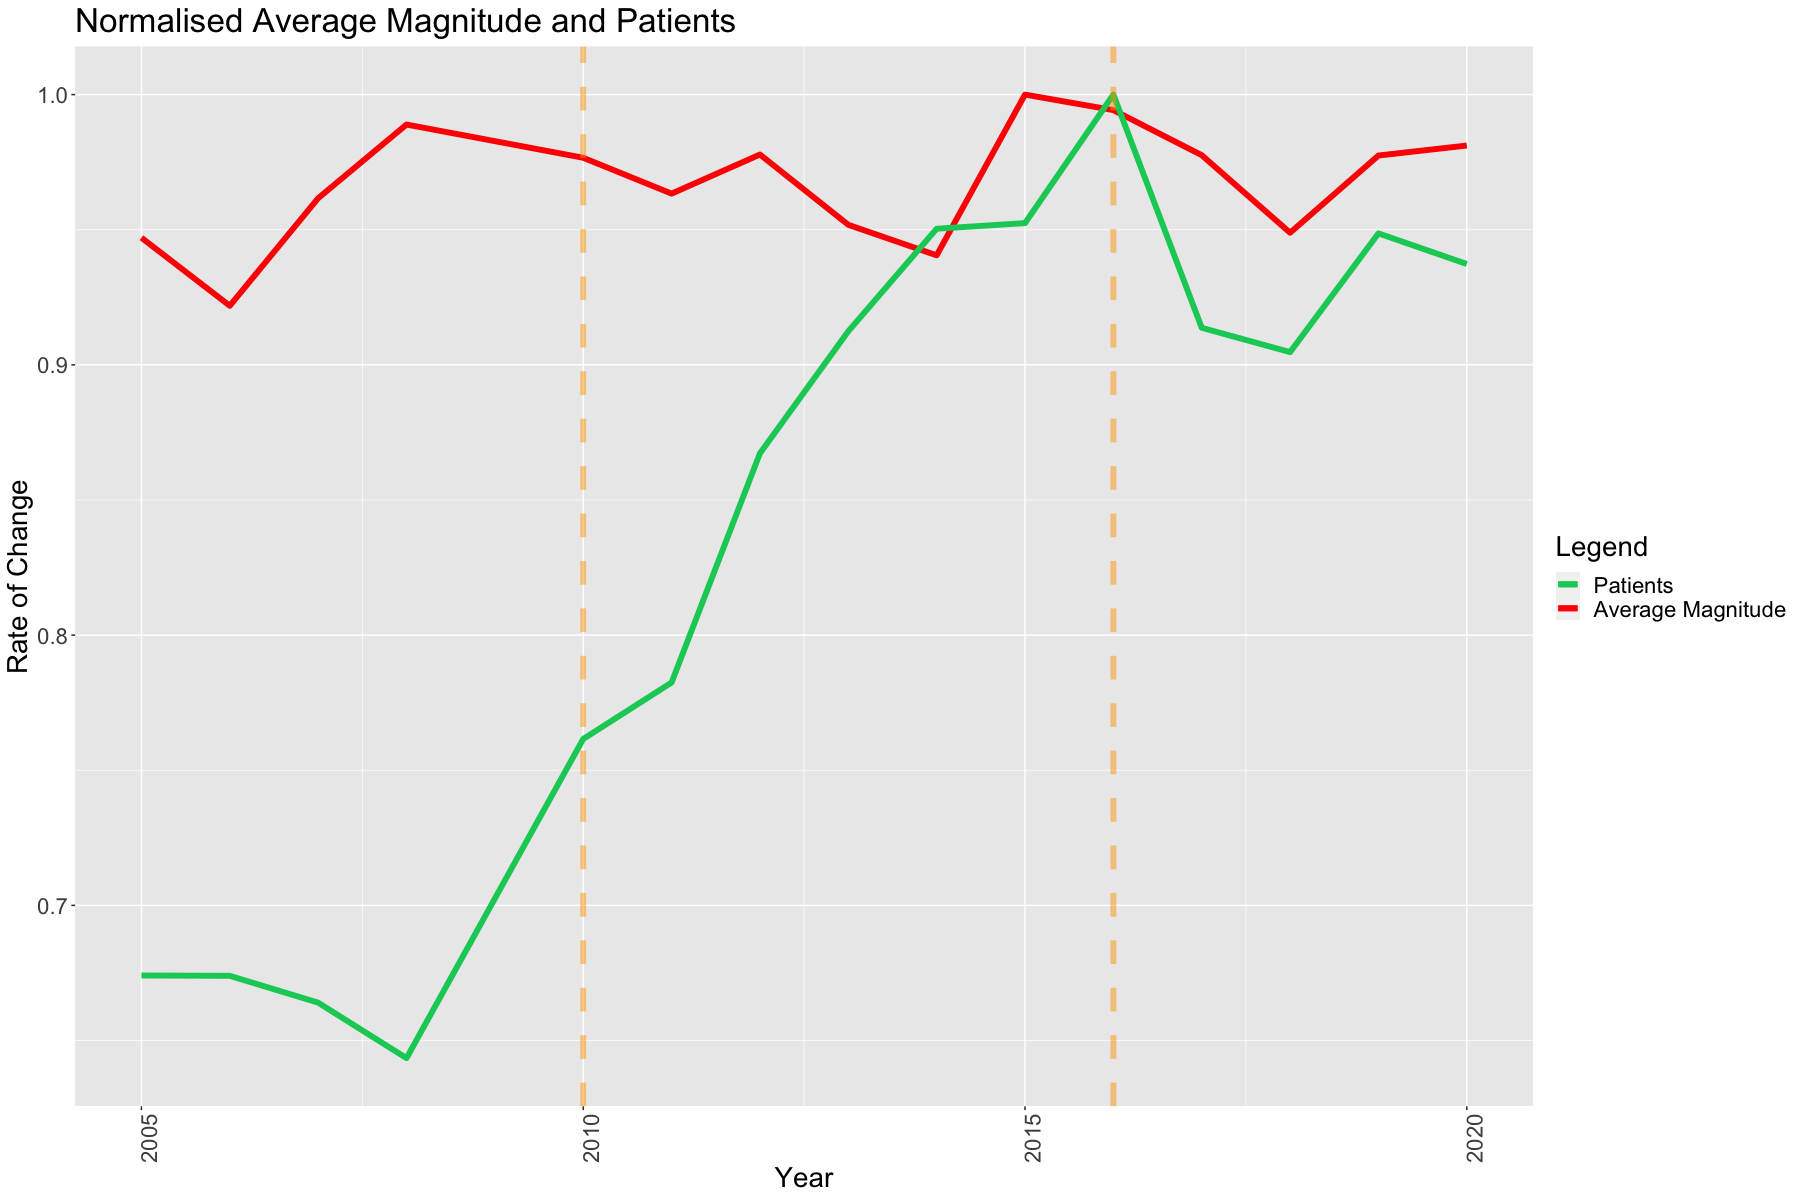

In [14]:
# defining colour
colours <- c("Patients" = "springgreen3", "Average Magnitude" = "red")

# num eq change rate vs mental health patients change rate for Canterbury
joined_table %>% filter(City=='Canterbury') %>%
  ggplot( aes(x=Year)) +
    geom_line(aes(y=Average_mag/max(Average_mag, na.rm=TRUE), color="Average Magnitude"), size=2) + # normalised num quakes
    geom_line(aes(y=Total/max(Total, na.rm=TRUE), color='Patients'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Average Magnitude and Patients") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))

##### The yellow vertical lines indicates the two major earthquakes in Canterbury, first one is 2010 Canterbury EQ and second one is 2016 Kaikoura EQ.

>green line -> population of mental health,red -> normalised maximum magnitude

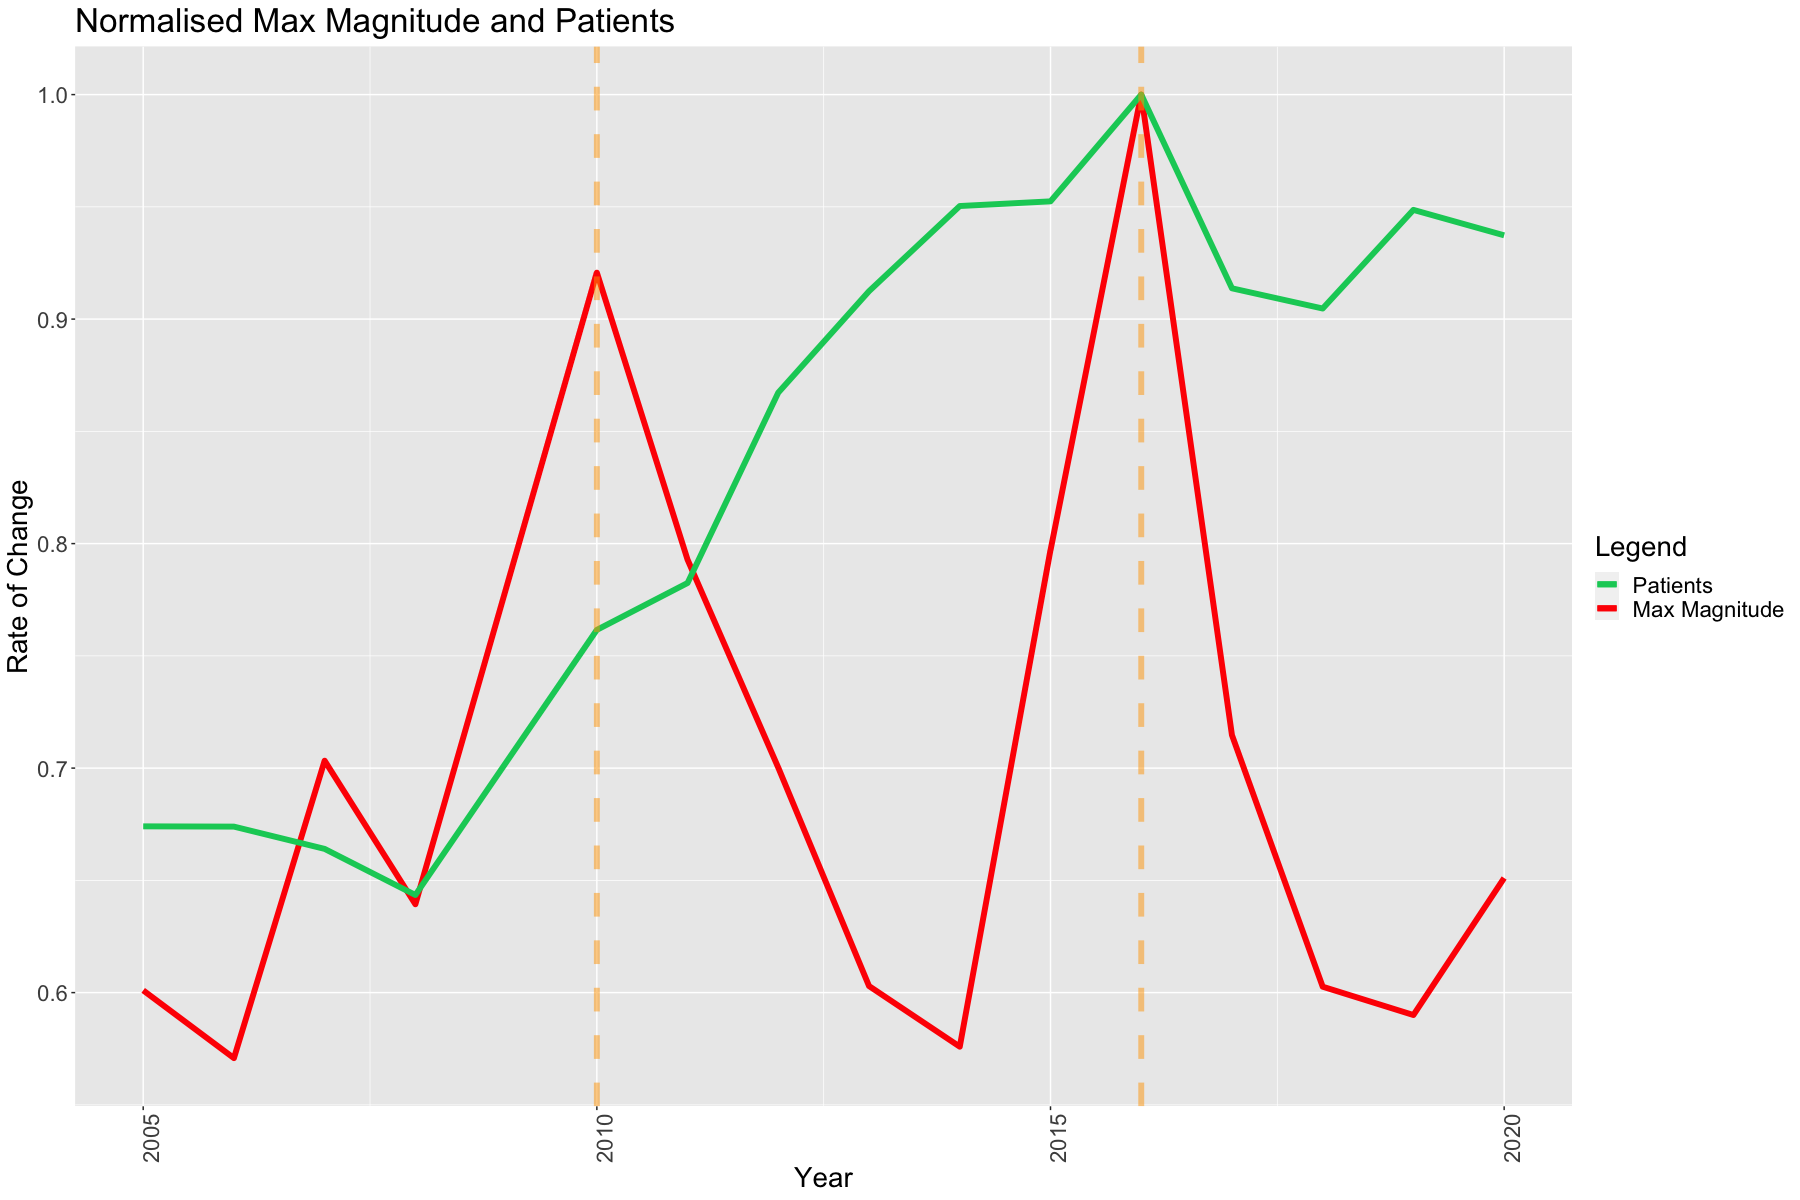

In [15]:
# defining colour
colours <- c("Patients" = "springgreen3", "Max Magnitude" = "red")

# num eq change rate vs mental health patients change rate for Canterbury
joined_table %>% filter(City=='Canterbury') %>%
  ggplot( aes(x=Year)) +
    geom_line(aes(y=Max_mag/max(Max_mag, na.rm=TRUE), color="Max Magnitude"), size=2) + # normalised num quakes
    geom_line(aes(y=Total/max(Total, na.rm=TRUE), color='Patients'), size=2) + # normalised pop.change.rate
    ggtitle("Normalised Max Magnitude and Patients") +
    geom_vline(xintercept=2010, color="orange", size=2, alpha=0.5, linetype='dashed') +
    geom_vline(xintercept=2016, color="orange", size=2, alpha=0.5, linetype='dashed') +
    labs(y="Rate of Change", color = "Legend") +
    scale_color_manual(values = colours) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1))